# Pan01 Mid Depth Temperature

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42875,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34489,Total threads: 1
Dashboard: /proxy/38051/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34827,


In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [7]:
# Time variant variables
def preprocess(ds):
    ds = ds[['thetao','so','volcello']].sel(yh=slice(None,-55)).sel(z_l=slice(400,600))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
cont

<xarray.Dataset> Size: 12GB
Dimensions:   (time: 120, z_l: 4, yh: 584, xh: 3600)
Coordinates:
  * xh        (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh        (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
  * z_l       (z_l) float64 32B 423.7 468.4 517.6 571.6
  * time      (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Data variables:
    thetao    (time, z_l, yh, xh) float32 4GB dask.array<chunksize=(2, 4, 242, 1030), meta=np.ndarray>
    so        (time, z_l, yh, xh) float32 4GB dask.array<chunksize=(2, 4, 242, 1030), meta=np.ndarray>
    volcello  (time, z_l, yh, xh) float32 4GB dask.array<chunksize=(2, 4, 242, 1030), meta=np.ndarray>
Attributes:
    NumFilesInSet:     1
    title:             panan
    associated_files:  areacello: 19910101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [10]:
# Area
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

We want to convert into conservative temperature to match ACCESS.  
We will need to:  
- (a) Calculate pressure from depths using `p_from_z` using `z_l` with a minus because the function has the z axis with zero at the surface and positive upwards
- (b) Calculate absolute salinity using `SA_from_SP`
- (c) Calculate conservative temperature using `CT_from_pt`

### Time mean for mapping

In [11]:
cont_map = cont.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')
melt_map = melt.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [12]:
cont_map = cont_map.load()
melt_map = melt_map.load()

In [13]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_map['z_l'], cont_map['yh'])
p_melt = gsw.p_from_z(-melt_map['z_l'], melt_map['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_map['so'], p_cont, cont_map['xh'], cont_map['yh'])
SA_melt =  gsw.SA_from_SP(melt_map['so'], p_melt, melt_map['xh'], melt_map['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont_map['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt_map['thetao'])

In [14]:
tempC

<xarray.DataArray 'so' (z_l: 4, yh: 584, xh: 3600)> Size: 67MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.44142768, 1.4321926 , 1.42679314, ..., 1.51638754,
         1.48435425, 1.45889186],
        [1.43747795, 1.4290634 , 1.42269741, ..., 1.50510627,
         1.47515393, 1.45239692],
        [1.43384302, 1.42582108, 1.41854436, ..., 1.49303637,
         1.46592901, 1.44640075]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [1.35306534, 1.34382987, 1.33834687, ..., 1.42987082,
         1.39603063, 1.37023302],
        [1.34893627, 1.34025749, 1.33374471, ..., 1.41884417,
         1.38728492, 1.36395845],
        [1.34525258, 1.33680163, 1.32930209, ..., 1.40699851,
         1.37843524, 1.35816757]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.29934885, 1.29039623, 1.28503631, ..., 1.37554578,
         1.34140041, 1.31595789],
        [1.29522909, 1.28666533, 1.28024379, ..., 1.36486883,
         1.3330851 , 1.3099463 ],
        [1.29161134, 1.28318156, 1.27573316, ..., 1.35337576,
         1.32462699, 1.30440823]]])
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6

In [15]:
tempC = tempC.load()#.astype('float32').load()

In [16]:
tempM = tempM.load()#.astype('float32').load()

In [17]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont_map['thetao'].dims, coords=cont_map['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt_map['thetao'].dims, coords=melt_map['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [18]:
tempM

<xarray.DataArray 'CT' (z_l: 4, yh: 584, xh: 3600)> Size: 67MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.44944466, 1.4443059 , 1.44616077, ..., 1.52494554,
         1.49144538, 1.4654892 ],
        [1.44702803, 1.44396164, 1.44515747, ..., 1.51306247,
         1.48205788, 1.45948016],
        [1.44582895, 1.44384579, 1.44357846, ..., 1.50043908,
         1.47298376, 1.45467001]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [1.35916013, 1.35394488, 1.35509119, ..., 1.43717791,
         1.40150263, 1.37499186],
        [1.3565875 , 1.35309565, 1.35367825, ..., 1.42538152,
         1.39244141, 1.36920698],
        [1.3552321 , 1.35271387, 1.35191182, ..., 1.41282567,
         1.38364827, 1.36456867]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.30485771, 1.29982012, 1.3006657 , ..., 1.38253313,
         1.34638124, 1.32014122],
        [1.30227859, 1.29872704, 1.29900421, ..., 1.37101452,
         1.33769393, 1.31461299],
        [1.30091975, 1.29822323, 1.29719147, ..., 1.35873121,
         1.32922871, 1.31019719]]])
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6
Attributes:
    units:    °C

#### Taking the depth mean

In [19]:
volC_map = cont_map['volcello']
volM_map = melt_map['volcello']

volC = cont['volcello']
volM = melt['volcello']
volC

<xarray.DataArray 'volcello' (time: 120, z_l: 4, yh: 584, xh: 3600)> Size: 4GB
dask.array<getitem, shape=(120, 4, 584, 3600), dtype=float32, chunksize=(2, 4, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          m3
    long_name:      Ocean grid-cell volume
    cell_methods:   area:sum z_l:sum yh:sum xh:sum time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_volume

In [20]:
# Correcting area 
saltC = cont['so']
saltM = melt['so']

areaC_corr = areaC*(saltC.isel(time=0,z_l=0)*0 +1)
areaM_corr = areaM*(saltM.isel(time=0,z_l=0)*0 +1)

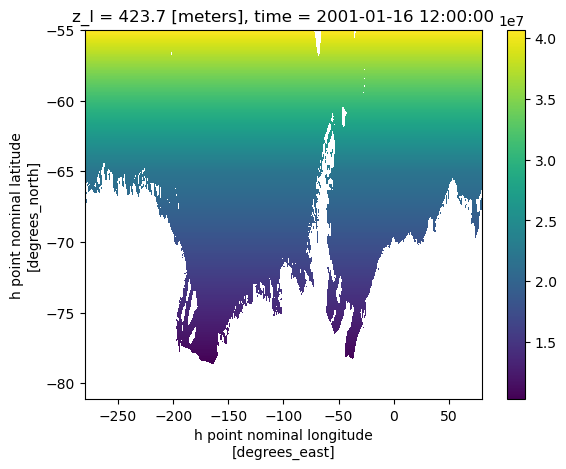

In [21]:
areaC_corr.plot()

In [22]:
thikC = volC / areaC_corr
thikM = volM / areaM_corr

In [23]:
thikC_map = volC_map / areaC_corr
thikM_map = volM_map / areaM_corr

In [24]:
thikC_map

<xarray.DataArray (z_l: 4, yh: 584, xh: 3600)> Size: 34MB
dask.array<divide, shape=(4, 584, 3600), dtype=float32, chunksize=(4, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
  * z_l      (z_l) float64 32B 423.7 468.4 517.6 571.6
    time     object 8B 2001-01-16 12:00:00

In [25]:
tempC_mid_map = tempC.weighted(thikC_map.fillna(0)).mean('z_l')
tempM_mid_map = tempM.weighted(thikM_map.fillna(0)).mean('z_l')

In [26]:
tempC_mid_map = tempC_mid_map.load()

In [27]:
tempM_mid_map = tempM_mid_map.load()

In [28]:
temp_anom_mid = tempM_mid_map - tempC_mid_map
temp_anom_mid = temp_anom_mid.load()

In [29]:
temp_anom_mid

<xarray.DataArray 'CT' (yh: 584, xh: 3600)> Size: 17MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00652953, 0.01054902, 0.01728718, ..., 0.00761072, 0.00584348,
        0.00517257],
       [0.00807343, 0.01327504, 0.02043731, ..., 0.00687549, 0.00555287,
        0.00565927],
       [0.01042037, 0.01634937, 0.02309047, ..., 0.00619375, 0.00562332,
        0.00681339]])
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 5kB -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
    time     object 8B 2001-01-16 12:00:00

In [32]:
temp_anom_mid.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/mid_temp_map_Pan01.nc')

#### Mapping

In [39]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

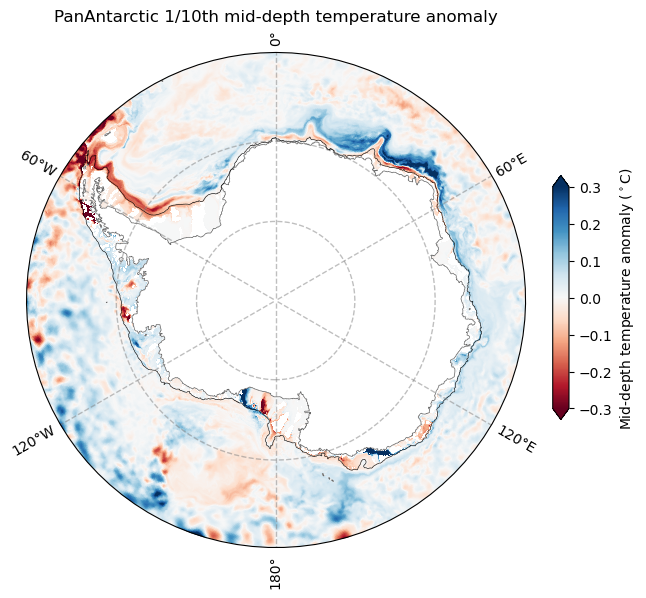

In [40]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
temp_anom_mid.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap= 'RdBu', #cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Mid-depth temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th mid-depth temperature anomaly");

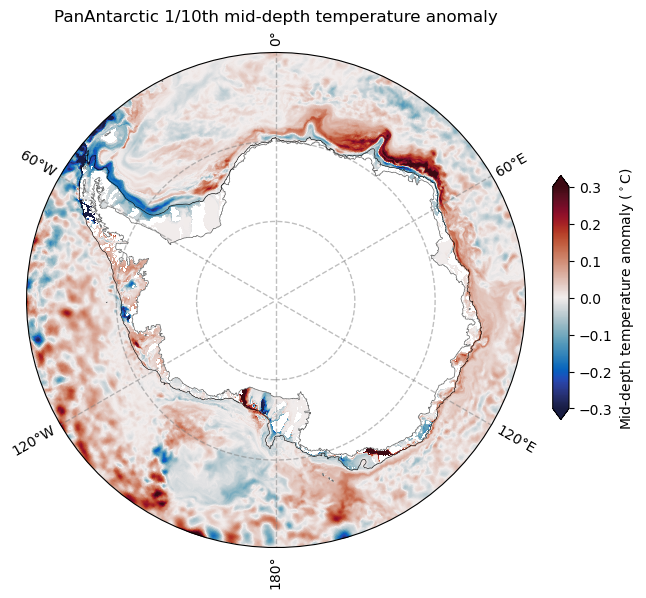

In [41]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
temp_anom_mid.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.3,
    vmax=0.3,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Mid-depth temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th mid-depth temperature anomaly");

## Time series

#### Time series

In [20]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

In [21]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [22]:
# Depth average
tempC_mid = (thikC * tempC).sum(['z_l']) / thikC.sum(['z_l'])
tempM_mid = (thikM * tempM).sum(['z_l']) / thikM.sum(['z_l'])

In [23]:
# Just shelf 
tempC_shelf = tempC_mid.where(shelf_mask == 1)
tempM_shelf = tempM_mid.where(shelf_mask == 1)

In [24]:
tempC_shelf.astype('float32').isel(time=0)

<xarray.DataArray (yh: 533, xh: 3600)> Size: 8MB
dask.array<getitem, shape=(533, 3600), dtype=float32, chunksize=(194, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -55.18 -55.12 -55.07
    time     object 8B 2001-01-16 12:00:00

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

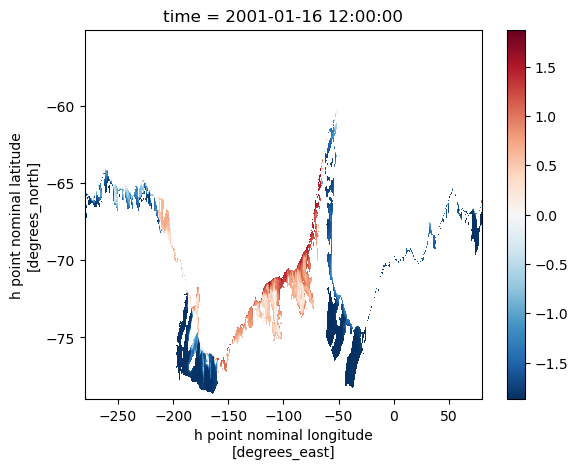

In [25]:
tempC_shelf.astype('float32').isel(time=0).plot()

In [26]:
# Spatial average
tempC_time = (areaC_corr * tempC_shelf).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
tempM_time = (areaM_corr * tempM_shelf).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

In [27]:
tempC_time

<xarray.DataArray (time: 120)> Size: 960B
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 423.7
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [28]:
tempC_time = tempC_time.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

In [29]:
tempM_time = tempM_time.load()

Text(0.5, 1.0, 'PanAn 1/10th Time Series of Mid-depth Temperature on Shelf')

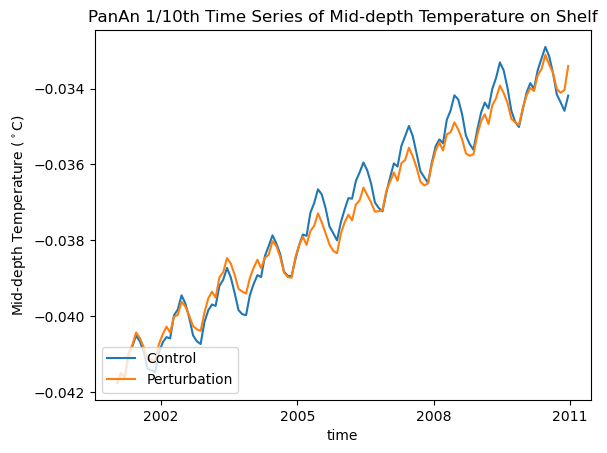

In [30]:
tempC_time.plot(label="Control")
tempM_time.plot(label="Perturbation")
plt.ylabel("Mid-depth Temperature ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("PanAn 1/10th Time Series of Mid-depth Temperature on Shelf")

In [31]:
midtemp_anom_time = tempM_time - tempC_time
midtemp_anom_time = midtemp_anom_time.load()

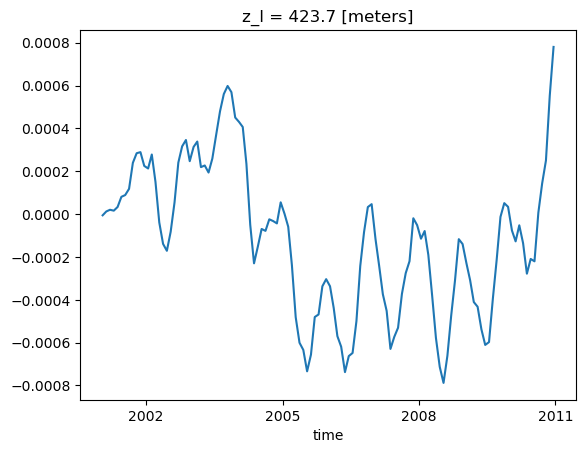

In [32]:
midtemp_anom_time.plot()

In [33]:
midtemp_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_anom_CT_pan01.nc')